<div class="alert alert-block alert-success">
    
# FIT5196 Task 3 in Assessment 1

Student Name: Anushka Jemima

Student ID: 33617457

Student Name: Shruthi Shashidhara Shastry

Student ID: 33684669

Date: 30-08-2024

Environment: Python

Libraries used:
* **re:** to define and use regular expressions
* **pandas:** to work with dataframes
* **json:** for parsing JSON data
* **gzip,os:** for file handling and system interaction.
* **matplotlib,seaborn** : for data visulaisation
    
</div>

<div class="alert alert-block alert-danger">
    
## Table of Contents

</div>    

[1. Introduction](#Intro) <br>
[2. Importing Libraries](#libs) <br>
[3. Examining Raw Data(given input file from task1)](#examine1) <br>
[4. Examining metadata](#examine2) <br>
[5. Data Analysis](#DA) <br>
    - [5.1 Question 1: How is xxxx related to xxxx?](#DI1) <br>
    - [5.2 Question 2: How does xxxxxx impact the rating of a business?](#DI2) <br>
[6. Summary](#summary) <br>
[7. References](#Ref) <br>

<div class="alert alert-block alert-warning">

## 1.  Introduction  <a class="anchor" name="Intro"></a>
    
</div>
Based on the Google review data provided for multiple businesses in California, we are now diving into an Exploratory Data Analysis (EDA) with a focus on business ratings. This analysis is crucial for understanding the factors that influence a business's success in the digital age.

Our approach involves several key steps:
1. Examining and cleaning the raw data
2. Identifying initial trends
3. Extracting deeper insights through various analytical techniques

The outcomes of this EDA will serve multiple purposes:
- Provide context for future research and predictive modeling
- Help businesses understand how they can improve their ratings
- Offer valuable insights into customer behavior and preferences

We're working with two primary datasets:
1. Google Review data: Contains detailed information about individual reviews
2. Metadata: Provides additional context about the businesses

By combining these datasets, we aim to uncover meaningful patterns and relationships that could be invaluable for business owners, marketers, and researchers alike.

<div class="alert alert-block alert-warning">
    
## 2.  Importing Libraries  <a class="anchor" name="libs"></a>
 </div>

The packages to be used in this assessment are imported in the following. They are used to fulfill the following tasks:

* **re:** to define and use regular expressions
* **pandas:** to work with dataframes
* **json:** for parsing JSON data
* **gzip,os:** for file handling and system interaction.
* **matplotlib,seaborn** : for data visulaisation



In [1]:
import json
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from textblob import TextBlob

These libraries enable us to efficiently process, analyze, and visualize our data

<div class="alert alert-block alert-warning">

## 3.  Examining Raw Data(given input file from task1) <a class="anchor" name="examine1"></a>

 </div>

We want to extract the raw data from the text files and excel files similar to what was done in Task1 using regular expressions.

In [2]:
#Mount the goole drive , to access files stored your google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

# Set the path where your txt files are saved
dir_path = '/content/drive/Shareddrives/FIT5196_S2_2024/GroupAssessment1/Student Data/student_group103'
# Create a list to hold all the data betweene the open and close record tags
records = []
#Loop through the files in the path
for file in os.listdir(dir_path):
  #only select the txt files
  if file.endswith('.txt'):
    #add the txt file name to create a file path
    file_path = os.path.join(dir_path,file)
   #Read the file
    with open(file_path,'r',encoding ='utf-8') as txtfile:
      #Set a buffer to hold the lines till a close tag of record is found
      record_buffer =""
      #Set a flag to check if the values are still in the same record open and close tag
      in_record = False
      #Count to save the line count
      line_count = 0
      # For each line extracted from the txt file
      for line in txtfile:
        #Check if a single line has both and open tag and a close tag of the record
        if re.search(r'\s*<record>\s*', line, re.IGNORECASE) and re.search(r'\s*</record>\s*', line, re.IGNORECASE):
          #If we are already inside a record tag then apped the other lines of the record till you find a close record tag
          if in_record:
            # check if a close record tag is found
            pre_end = re.search(r'(.*?)</record>', line).group(1)
            #add all the text before the close tag to your current record
            record_buffer += pre_end
            # append this record to the buffer holding all records
            records.append([record_buffer])
            #initialize buffer to empty cause we have stored a full record
            record_buffer = ""
            in_record = False
          #if and open tag and close tag occur one after the other on a single line
          #store the full record to the records list
          full_record = re.search(r'<record>(.*?)</record>',line)
          if full_record:
            records.append([full_record.group(1)])
          #search for the close record tag and text after it
          post_start = re.search(r'</record>(.*)',line)
          # if the text after the close record tage has an open record tag and some text
          if post_start and '<record>' in post_start.group(1):
            # store it in the record buffer as a new record
            record_buffer = re.search(r'<record>(.*)',post_start.group(1)).group(1)
            in_record = True
        else:
          # if open and close record tags were not in the same line
          # check if the line has an open record tag
          if re.search(r'\s*<record>\s*', line, re.IGNORECASE):
            # store all data after the tag into the buffer
            record_buffer = re.search(r'<record>(.*)',line).group(1)
            in_record = True
          # if the line has close record tag
          elif re.search(r'\s*</record>\s*', line, re.IGNORECASE):
               #search if a closed record tag is in the line
                pre_end = re.search(r'(.*?)</record>',line).group(1)
                # the text before the close tag is added to the record buffer
                record_buffer += pre_end
                records.append([record_buffer])
                record_buffer = ""
                in_record = False
         #if the line has just text and no open tag or close tag
          elif in_record:
                # the just add it to the record buffer holding all the curremt record values
                record_buffer += line


#Create a disctionary to store the patterns for each of the fields you wnat to extract
patterns = {
    # Search for the opening tag < , gmap and then a closing tag extract text between this and the next opening tag</gmap...>
    'GmapID': re.compile(r'<[^>]*gmap[^>]*>(.*?)<[^>]*/[^>]*gmap[^>]*>', re.DOTALL | re.IGNORECASE),
    # Search for the opening tag < , resp and then a closing tag extract text between this and the next opening tag</resp...>
    #Ensures if response is used inside the tags it is still picked up
    'Response': re.compile(r'<[^>]*resp[^>]*>(.*?)<[^>]*/[^>]*resp[^>]*>', re.DOTALL | re.IGNORECASE),
    # Search for the opening tag < , pic and then a closing tag extract text between this and the next opening tag</pic...>
    'Pics': re.compile(r'<[^>]*pic[^>]*>(.*?)<[^>]*/[^>]*pic[^>]*>', re.DOTALL | re.IGNORECASE),
    # Search for the opening tag < , rat and then a closing tag extract text between this and the next opening tag</rat...>
    'Rate': re.compile(r'<[^>]*rat[^>]*>(.*?)<[^>]*/[^>]*rat[^>]*>', re.DOTALL | re.IGNORECASE),
    # Search for the opening tag < , name and then a closing tag extract text between this and the next opening tag</name...>
    'Name': re.compile(r'<[^>]*name[^>]*>(.*?)<[^>]*/[^>]*name[^>]*>', re.DOTALL | re.IGNORECASE),
    # Search for the opening tag < , user and then a closing tag extract text between this and the next opening tag</user...>
    #Look for combinations that have user and the word id after it , but dont select combinations of user and name
    'UserId': re.compile(r'<[^>]*\s*user(?![_\s]*name\b)(?:\s*_id)?\s*[^>]*>(.*?)<[^>]*\s*\/\s*user(?:\s*_id)?\s*[^>]*>', re.DOTALL | re.IGNORECASE),
    # Search for the opening tag < , review or text and then a closing tag extract text between this and the next opening tag</review or text...>
    'Review': re.compile(r'<[^>]*(?:review|text)[^>]*>(.*?)<[^>]*/(?:review|text)[^>]*>', re.DOTALL | re.IGNORECASE),
    # Search for the opening tag < , date or time and then a closing tag extract text between this and the next opening tag</date or time...>
    'Date': re.compile(r'<[^>]*(?:date|time)[^>]*>(.*?)<[^>]*/(?:date|time)[^>]*>', re.DOTALL | re.IGNORECASE)
}

In [4]:
#Initialize a list to store your data
all_data =[]
#Loop through each record within the list of records
for record in records:
  #Select the first index that holds all the text
  record_str = record[0]
  #Create a dictionary
  data = {}
  #Loop through each key value pair fom the patterns define previously
  for key, pattern in patterns.items():
    # Search for the pattern which is the value for each key
    find = pattern.search(record_str)
    # Check any text is found
    if find :
      # Save it to the data disctionary
      data[key] = find.group(1)
    else :
      # Otherwise set it as empty , this can be used to check if all the values are being captured
      data[key] = ' '
  #Append this disctionary to the main all_data
  all_data.append(data)
#Convert the list to a data frame
df = pd.DataFrame(all_data)

#Loop through each column
for column in df.columns:
    if df[column].dtype == object:
      #Remove any new line characters from the ends of the data extracted
        df[column] = df[column].str.strip('\n')


In [5]:
# Set the path to the excel file
ex_file_path = '/content/drive/Shareddrives/FIT5196_S2_2024/GroupAssessment1/Student Data/student_group103/group103.xlsx'
# Define the column names
cols = ['user_id','name','time','rating','text','pics','resp','gmap_id']
#Create a list to hold all extracted rows
data =[]

#Load the excel file
with pd.ExcelFile(ex_file_path) as xls:
  #Loop through each sheet
  for sheet in xls.sheet_names:
    try:
      #Read each row of the sheet
      df_read = pd.read_excel(xls,sheet_name = sheet,usecols = cols)
      # Append each row which represents a single record to the list
      data.append(df_read)
    except ValueError as e:
      #This checks for any errors in reading the sheet
      print(f"Error {sheet}:{e}")
#Combine all the rows extracted from each sheet
combined_ex = pd.concat(data,ignore_index=True)
#Set column name as preferred
combined_ex.rename(columns={'user_id':'UserId',
                             'name':'Name',
                              'time': 'Date',
                            'rating': 'Rate',
                            'text':'Review',
                            'pics':'Pics',
                            'resp':'Response',
                            'gmap_id':'GmapID'},inplace=True)
#Combine the data extracted from txt files with that extracted from excel files
comp_data = pd.concat([df,combined_ex],ignore_index=True)



In [6]:
# Display basic information about the dataset
print("Dataset Info:")
print(comp_data.info())
print("\nSummary Statistics:")
print(comp_data.describe())
print("\nFirst few rows of the DataFrame:")
comp_data.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41944 entries, 0 to 41943
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   GmapID    41909 non-null  object
 1   Response  39869 non-null  object
 2   Pics      39868 non-null  object
 3   Rate      41909 non-null  object
 4   Name      41909 non-null  object
 5   UserId    41909 non-null  object
 6   Review    41211 non-null  object
 7   Date      41909 non-null  object
dtypes: object(8)
memory usage: 2.6+ MB
None

Summary Statistics:
                                       GmapID Response   Pics   Rate  \
count                                   41909    39869  39868  41909   
unique                                    176     8115    948     10   
top     0x8085165e303fad4f:0xf0b0116f98a09f83     None   None      5   
freq                                     3984    31714  38889  27862   

                 Name                 UserId Review           Date  
co

,GmapID,Response,Pics,Rate,Name,UserId,Review,Date
0,0x80dcd7966cd83693:0x1b66577f943dd08a,"{'time': 1620926001976, 'text': 'Blake H., tha...",None,1,Blake H.,107261011106549619258,Had a wonderful time for 1.5 years here; perfe...,1618865599632
1,0x80dcd7966cd83693:0x1b66577f943dd08a,"{'time': 1511742549116, 'text': 'Guillermo, th...",[{'url': ['https://lh5.googleusercontent.com/p...,1,Me G,116051235011279532166,"BEWARE I’m WARNING you....issues with parking,...",1542141991127
2,0x80dcd7966cd83693:0x1b66577f943dd08a,"{'time': 1621904115358, 'text': 'Isabel Verde,...",None,1,Isabel Verde,102925152838434772121,The leasing office at this facility should be ...,1621218319872
3,0x80dcd7966cd83693:0x1b66577f943dd08a,"{'time': 1622842850432, 'text': 'Hi Jessica, t...",None,4,Jessica Santa Cruz,105305850418052538268,Got an Airbnb here and was disappointed. The ...,1622046287724
4,0x80dcd7966cd83693:0x1b66577f943dd08a,"{'time': 1501511330802, 'text': 'James Smith, ...",[{'url': ['https://lh5.googleusercontent.com/p...,5,James Smith,114773690064027559272,Jefferson Platinum Triangle is amazing! Perfec...,1524622075722


<div class="alert alert-block alert-warning">

## 4.  Examining Metadata <a class="anchor" name="examine2"></a>

 </div>

In this section, we're loading and examining the metadata as follows:

In [7]:
def load_json_file(file_path):
    data = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        for line in file:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Skipping line due to JSONDecodeError: {e}")
    return data

# Convert JSON to DataFrame
def json_to_dataframe(json_data):
    df = pd.json_normalize(json_data)
    return df

# Load JSON files
json_file_path = '/content/drive/Shareddrives/FIT5196_S2_2024/GroupAssessment1/meta-California.json.gz'
json_data = load_json_file(json_file_path)

df_metadata = json_to_dataframe(json_data)

# Display basic information about the dataset
print("Dataset Info:")
print(df_metadata.info())
print("\nSummary Statistics:")
print(df_metadata.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515961 entries, 0 to 515960
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   name                    515951 non-null  object 
 1   address                 508257 non-null  object 
 2   gmap_id                 515961 non-null  object 
 3   description             111921 non-null  object 
 4   latitude                515961 non-null  float64
 5   longitude               515961 non-null  float64
 6   category                513585 non-null  object 
 7   avg_rating              515961 non-null  float64
 8   num_of_reviews          515961 non-null  int64  
 9   price                   109801 non-null  object 
 10  hours                   414982 non-null  object 
 11  MISC                    0 non-null       float64
 12  state                   372248 non-null  object 
 13  relative_results        475497 non-null  object 
 14  url   

In [8]:
print("\nFirst few rows of the DataFrame:")
df_metadata.head()


First few rows of the DataFrame:


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,...,MISC.Dining options,MISC.Crowd,MISC.Planning,MISC.From the business,MISC.Recycling,MISC.Highlights,MISC.Getting here,MISC.Activities,MISC.Health and safety,MISC.Lodging options
0,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,None,34.018891,-118.215290,[Textile exporter],4.5,6,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",0x80c2c89923b27a41:0x32041559418d447,None,34.023669,-118.232930,[Fabric store],3.3,6,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",0x80c2c632f933b073:0xc31785961fe826a6,None,34.036694,-118.249421,[Fabric store],4.3,7,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Matrix International Textiles,"Matrix International Textiles, 1363 S Bonnie B...",0x80c2cf163db6bc89:0x219484e2edbcfa41,None,34.015505,-118.181839,[Fabric store],3.5,6,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-warning">

## 5.  Initial Exploration <a class="anchor" name="DA"></a>

 </div>

 In this section, we begin our exploratory data analysis by cleaning both the Google review data and the metadata. Our goal is to identify and handle any data quality issues before proceeding with more in-depth analysis.


**Google Review Data Exploration**


First, we examine the Google review data for null values and duplicates:

In [9]:
#Check if the data frame has any row which has all columns as null
nulls = comp_data.isnull().sum()
print(nulls)
# Drop only those rows where no values are present under any column
comp_data = comp_data.dropna(how='all')
print(comp_data.dtypes)

#Remove any unnecessary space at the end or beginning of the value under a column
comp_data = comp_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

GmapID        35
Response    2075
Pics        2076
Rate          35
Name          35
UserId        35
Review       733
Date          35
dtype: int64
GmapID      object
Response    object
Pics        object
Rate        object
Name        object
UserId      object
Review      object
Date        object
dtype: object


<ipython-input-9-32e29fd658f3>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  comp_data = comp_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [10]:
# Count of records before removing duplicates
record_count_d = len(comp_data)

# Check for duplicates
duplicate_count = comp_data.duplicated().sum()

# Drop any duplicate rows from the DataFrame, retaining only the first occurrence of the rows
comp_data = comp_data.drop_duplicates()

# Count of records after removing duplicates
record_count = len(comp_data)

# Display
print(f"Count of records before removing duplicates: {record_count_d}")
print(f"Count of duplicate rows: {duplicate_count}")
print(f"Count of records after removing duplicates: {record_count}")

Count of records before removing duplicates: 41909
Count of duplicate rows: 464
Count of records after removing duplicates: 41445


**Metadata Exploration**

Next, we examine the metadata for missing values and overall structure:

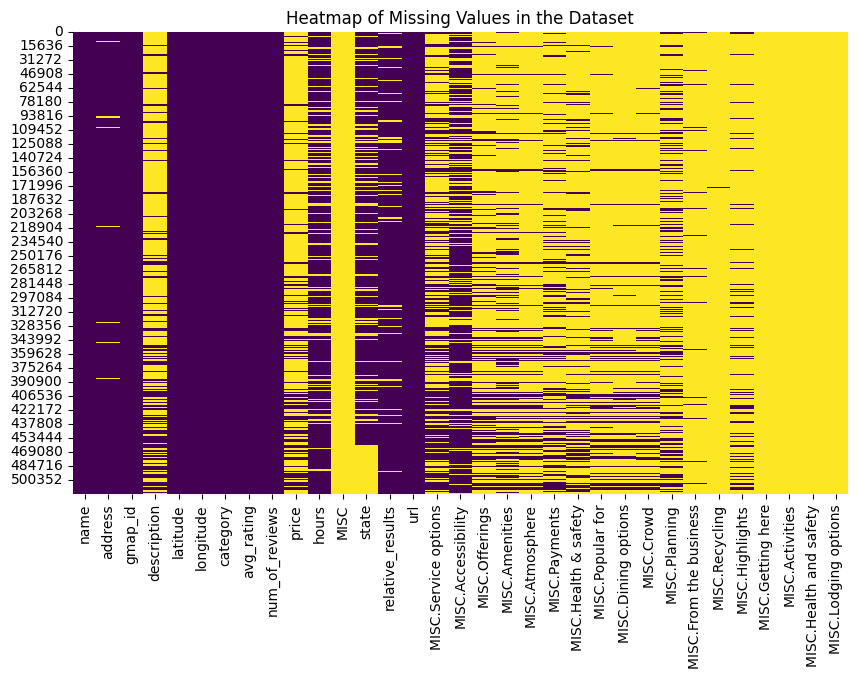

In [11]:
# Visualizing missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df_metadata.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values in the Dataset')
plt.show()

In [12]:
#As there are many null values based on threshold lets filtering only necessary columns required for analysis
threshold = 0.5
metadata = df_metadata.loc[:, df_metadata.isnull().mean() < threshold]
metadata

,name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,hours,state,relative_results,url,MISC.Accessibility
0,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,34.018891,-118.215290,[Textile exporter],4.5,6,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,NaN
1,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,34.058092,-118.292130,[Korean restaurant],4.4,18,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,[Wheelchair accessible entrance]
2,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",0x80c2c89923b27a41:0x32041559418d447,34.023669,-118.232930,[Fabric store],3.3,6,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,NaN
3,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",0x80c2c632f933b073:0xc31785961fe826a6,34.036694,-118.249421,[Fabric store],4.3,7,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,NaN
4,Matrix International Textiles,"Matrix International Textiles, 1363 S Bonnie B...",0x80c2cf163db6bc89:0x219484e2edbcfa41,34.015505,-118.181839,[Fabric store],3.5,6,"[[Thursday, 8:30AM–5:30PM], [Friday, 8:30AM–5:...",Open ⋅ Closes 5:30PM,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,[Wheelchair accessible entrance]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
515956,McDonald's,"McDonald's, 1728 Lomita Blvd, Lomita, CA 90717",0x80dd4a7afea27289:0xe49cfab49567e5cb,33.797530,-118.308527,"[Fast food restaurant, Breakfast restaurant, C...",4.1,830,"[[Wednesday, 5AM–12AM], [Thursday, 5AM–12AM], ...",NaN,"[0x80dd4a72339feac7:0xcb7398ed660df0b1, 0x80dd...",https://www.google.com/maps/place//data=!4m2!3...,"[Wheelchair accessible entrance, Wheelchair ac..."
515957,California Citrus State Historic Park,"California Citrus State Historic Park, 9400 Du...",0x80dcba7983a059af:0x2a006c069483d3d2,33.898611,-117.425703,"[Park, Tourist attraction]",4.7,763,"[[Wednesday, 8AM–5PM], [Thursday, 8AM–5PM], [F...",NaN,"[0x80dcb21eefbd19f5:0x8ebb31f8a91dc2d3, 0x80dc...",https://www.google.com/maps/place//data=!4m2!3...,[Wheelchair accessible entrance]
515958,California Citrus,"California Citrus, 1999 Van Buren Boulevard, R...",0x80dcb09e3af6228b:0xa55fc2f742364e02,33.898299,-117.428067,[State park],4.8,96,None,NaN,"[0x80dcb09dfb76baef:0x5156f914ebbbe, 0x80dcb1e...",https://www.google.com/maps/place//data=!4m2!3...,[Wheelchair accessible entrance]
515959,Recreation Park Playground,"Recreation Park Playground, 701-939 Federation...",0x80dd31c81d5f153d:0x501886193d0102e7,33.775862,-118.135669,[Playground],4.3,17,None,NaN,"[0x80dd31044c86de89:0xea5a9038c8f9e2eb, 0x80dd...",https://www.google.com/maps/place//data=!4m2!3...,[Wheelchair accessible entrance]


In [13]:
# Replace 'None' strings with NaN to handle them consistently
metadata.replace('None', pd.NA, inplace=True)
metadata.replace('none', pd.NA, inplace=True)

# After replacing 'None'
missing_values_after_replace = metadata.isnull().sum()
print("Missing Values per Column after replacing 'None':\n", missing_values_after_replace)

<ipython-input-13-47e4d94d3228>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.replace('None', pd.NA, inplace=True)


Missing Values per Column after replacing 'None':
 name                      12
address                 7704
gmap_id                    0
latitude                   0
longitude                  0
category                2376
avg_rating                 0
num_of_reviews             0
hours                 100979
state                 143713
relative_results       40464
url                        0
MISC.Accessibility    126030
dtype: int64


<ipython-input-13-47e4d94d3228>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.replace('none', pd.NA, inplace=True)


In [14]:
# Check for any NaN values in the dataframe after initial filtering
missing_values = metadata.isnull().sum()
print("Missing Values per Column:\n", missing_values)

# Filter columns that still have missing values
columns_with_nan = missing_values[missing_values > 0].index.tolist()
print("Columns with NaN values:", columns_with_nan)


Missing Values per Column:
 name                      12
address                 7704
gmap_id                    0
latitude                   0
longitude                  0
category                2376
avg_rating                 0
num_of_reviews             0
hours                 100979
state                 143713
relative_results       40464
url                        0
MISC.Accessibility    126030
dtype: int64
Columns with NaN values: ['name', 'address', 'category', 'hours', 'state', 'relative_results', 'MISC.Accessibility']


Handling the null values

In [15]:
#Code for handling null valuws
for column in columns_with_nan:
   # If the column is categorical or text
    if metadata[column].dtype == 'object':
       # fll with a placeholder
        metadata[column].fillna('No Information', inplace=True)
    else:  # If the column is numerical
        # fill with median value
        metadata[column].fillna(metadata[column].median(), inplace=True)

# Final check for missing values
print("Final Check - Any Missing Values?\n", metadata.isnull().sum())

<ipython-input-15-172c39d0a80d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata[column].fillna('No Information', inplace=True)


Final Check - Any Missing Values?
 name                  0
address               0
gmap_id               0
latitude              0
longitude             0
category              0
avg_rating            0
num_of_reviews        0
hours                 0
state                 0
relative_results      0
url                   0
MISC.Accessibility    0
dtype: int64


**Initial exploration through visulaisation**:
we conduct an initial exploration of our data to understand its structure, distribution, and potential patterns. This step is crucial for guiding our subsequent in-depth analysis.

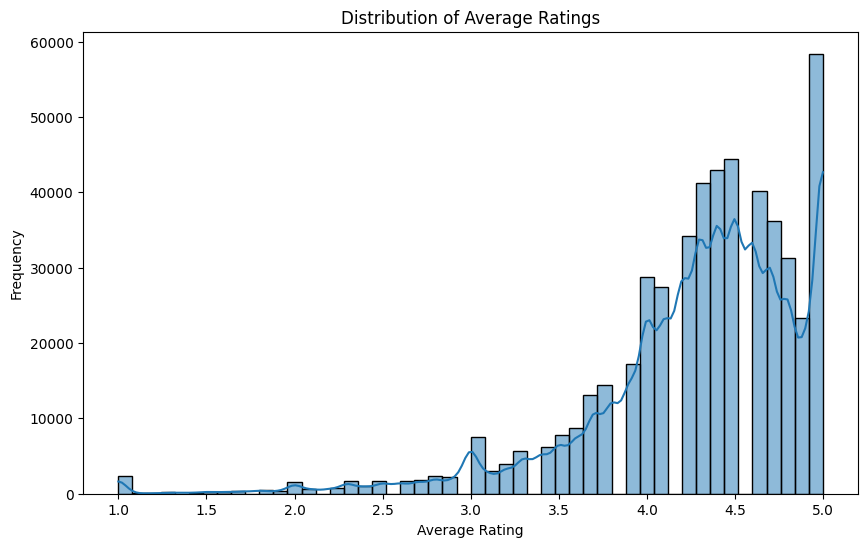

In [18]:
#In order to understand the distribution of average rating we are plotting its distribution as shown below
plt.figure(figsize=(10, 6))
sns.histplot(metadata['avg_rating'], bins=50, kde=True)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

**Distribution of Average Ratings:**
The histogram reveals a strong right-skew in the distribution of average ratings, with a peak around 4.5-5.0. This suggests that most businesses in the dataset have high average ratings, with fewer businesses receiving lower ratings. The sharp increase in frequency for ratings above 4.0 indicates a potential bias towards positive ratings or that businesses with lower ratings may be underrepresented in the dataset.

We merge the Google Review data with the Meta data , this is done to ensure I use only the data from the business in my google review data , since the meta data has multiple other business that may not be included in my data set. It would help us derived trends in the combined data set.

In [22]:
merged_data = pd.merge(comp_data, metadata, left_on='GmapID', right_on='gmap_id', how='left')

Number of unique categories: 293

Top 20 categories:
American restaurant: 6003
New American restaurant: 4182
Steak house: 3984
Restaurant: 3582
Discount store: 3384
Park: 2490
Medical diagnostic imaging center: 2246
Mammography service: 2246
MRI center: 2246
Radiologist: 2246
X-ray lab: 2246
Tourist attraction: 2203
Hiking area: 2048
Used car dealer: 1868
Auto repair shop: 1788
Car dealer: 1770
Car finance and loan company: 1581
Truck dealer: 1581
Used truck dealer: 1581
Family restaurant: 1467


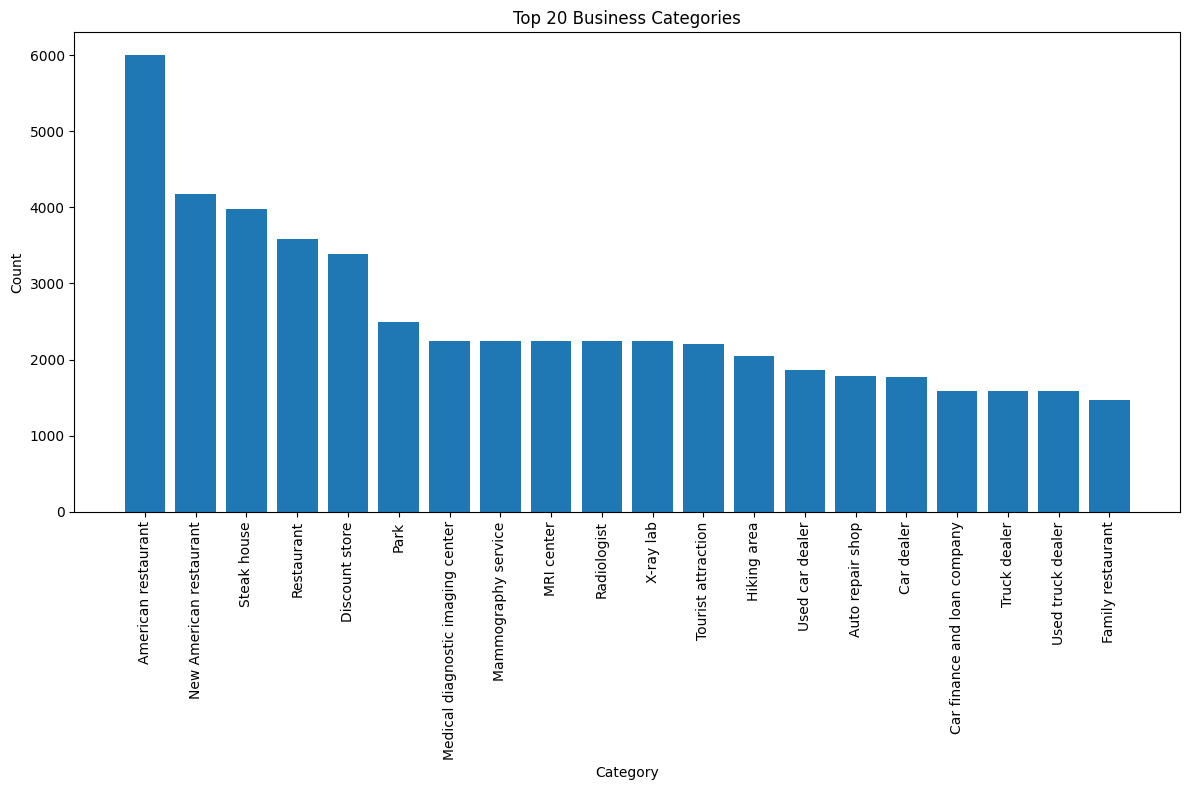

In [23]:
from collections import Counter

# Flatten the category lists and get unique categories
all_categories = [cat for cats in merged_data['category'] for cat in cats]
unique_categories = set(all_categories)
print(f"Number of unique categories: {len(unique_categories)}")

# Count occurrences of each category
category_counts = Counter(all_categories)

# Display top 20 categories
top_20_categories = dict(sorted(category_counts.items(), key=lambda x: x[1], reverse=True)[:20])
print("\nTop 20 categories:")
for cat, count in top_20_categories.items():
    print(f"{cat}: {count}")

# Visualize top 20 categories
plt.figure(figsize=(12, 8))
plt.bar(top_20_categories.keys(), top_20_categories.values())
plt.title('Top 20 Business Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



**Top 20 Business Categories:**
American restaurants dominate the dataset, followed by New American restaurants and steak houses. The diversity of categories, including both food service and non-food businesses like medical services and auto-related businesses, indicates a wide range of industries represented. This variety suggests that the analysis covers a broad spectrum of the service sector in California.


Top 10 categories by average rating:
Mortgage lender: 5.00
Real estate consultant: 5.00
Adult education school: 5.00
Training centre: 5.00
Insurance company: 5.00
Motorcycle insurance agency: 5.00
Life insurance agency: 5.00
Labor relations attorney: 5.00
First aid station: 5.00
Personal injury attorney: 5.00


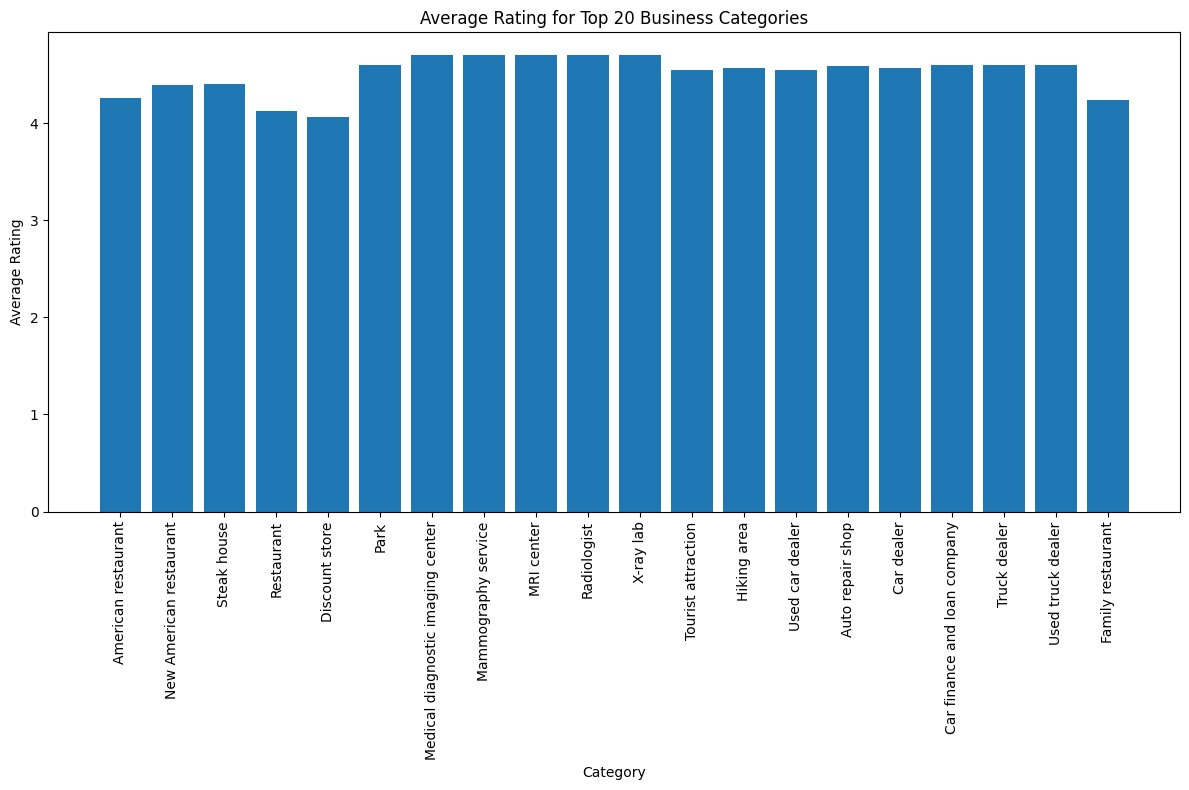

In [24]:
# Function to calculate average rating for each category
def avg_rating_for_category(category):
    mask = merged_data['category'].apply(lambda x: category in x)
    return merged_data.loc[mask, 'avg_rating'].mean()

# Calculate average rating for each unique category
avg_ratings = {cat: avg_rating_for_category(cat) for cat in unique_categories}

# Sort and display top 10 categories by average rating
top_10_by_rating = dict(sorted(avg_ratings.items(), key=lambda x: x[1], reverse=True)[:10])
print("\nTop 10 categories by average rating:")
for cat, rating in top_10_by_rating.items():
    print(f"{cat}: {rating:.2f}")

# Visualize average rating for top 20 categories by count
top_20_avg_ratings = {cat: avg_ratings[cat] for cat in top_20_categories.keys()}
plt.figure(figsize=(12, 8))
plt.bar(top_20_avg_ratings.keys(), top_20_avg_ratings.values())
plt.title('Average Rating for Top 20 Business Categories')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


**Average Rating for Top 20 Business Categories:**

The bar chart shows relatively high average ratings across all top 20 categories, with most falling between 4.0 and 4.5. Medical and health-related categories (e.g., radiologists, medical diagnostic centers) tend to have the highest average ratings, while some retail and auto-related businesses have slightly lower, but still positive, average ratings. This suggests generally high customer satisfaction across diverse business types, with some variation between sectors.

<div class="alert alert-block alert-warning">

## 6. Data Analysis <a class="anchor" name="DA"></a>

 </div>

In this section, we are looking into 5 data insights from the data. We believe that by looking into different factors that can impact on a business
rating, we can have a better understanding the importance of the rating and provide strategies on imrpoving the business rating and also use it
towards future predictions for a business.


 <div class="alert alert-block alert-info">
    
### 6.1.How is the number of reviews related to the average rating? <a class="anchor" name="DI1"></a>

This analysis explores the relationship between the number of reviews a business receives and its average rating. We use a scatter plot to visualize this relationship, with the x-axis representing the number of reviews and the y-axis showing the average rating. Each point on the plot represents a business.
The code generates a scatter plot using seaborn's scatterplot function and calculates the correlation coefficient between the number of reviews and the average rating.

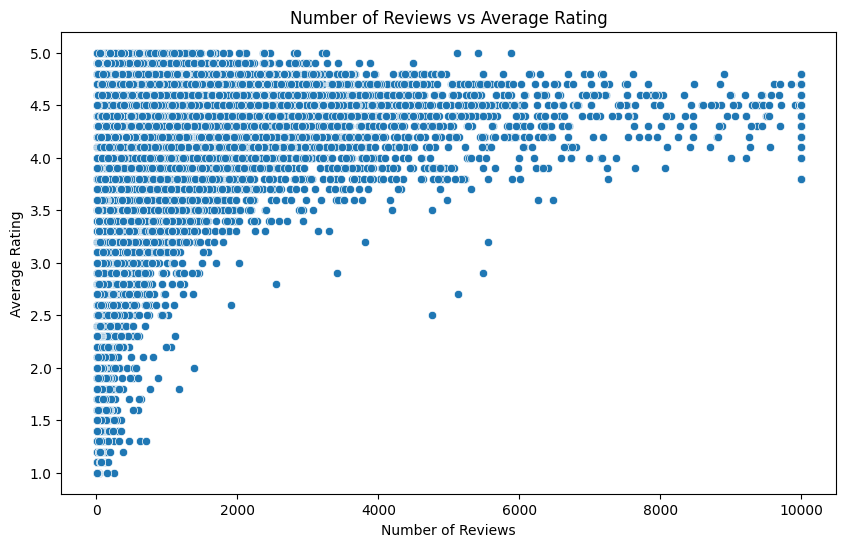

Correlation between Number of Reviews and Average Rating: 0.010777183255480133


In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_of_reviews', y='avg_rating', data=metadata)
plt.title('Number of Reviews vs Average Rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Average Rating')
plt.show()

correlation = metadata['num_of_reviews'].corr(metadata['avg_rating'])
print(f"Correlation between Number of Reviews and Average Rating: {correlation}")

**Interpretation of the visulaisation:**

The scatter plot and correlation coefficient (0.0107) reveal a negligible relationship or no linear relationship between the number of reviews and average rating for businesses. Despite the wide range of review counts (from a few to over 10,000) and ratings (mostly 3.5 to 5.0), there's no clear trend of ratings increasing or decreasing with more reviews. Businesses with high review counts  show more consistent ratings (3.5-4.5), while those with fewer reviews display greater rating variability.

This analysis suggests that the quantity of reviews does not significantly influence a business's average rating. For businesses, this implies that simply accumulating more reviews may not improve their rating; instead, focusing on quality of service and customer experience is likely more impactful. For consumers, it indicates that the number of reviews alone isn't a reliable quality indicator, and they should consider other factors and read review content when making decisions based on ratings.

<div class="alert alert-block alert-info">
    
### 6.2. How is Response to a Review related to a business Rating? <a class="anchor" name="DI1"></a>

To understand the importance of the response we would like to first split the data into two sets the high rated business and low rate business, and select a sample from this.

We use the Google Review Main data set , and average the rating for each business we then split based on the average rating calculated , since most of the ratings are between 3.0 and 5.0 we split it at 4.5 to get a better distribution of businesses.

In [28]:
#Convert the column to numeric values
merged_data['Rate'] = pd.to_numeric(merged_data['Rate'], errors='coerce')
#Group the gmap_id's and calulate the mena of the rating
average_ratings = merged_data.groupby('GmapID')['Rate'].mean().sort_values()

# Display the resulting DataFrame
#Select records with average rating higher than 4.5
gmap_ids_above_4 = average_ratings[average_ratings >= 4.5].sort_values(ascending=False)
#Select records with average rating lower than 4.5
gmap_ids_below_4 = average_ratings[average_ratings < 4.5].sort_values(ascending=False)
#Select the top 5 gmap_ids for each fo the split sets
top_5_above_4 = gmap_ids_above_4.head(5).index.tolist()
top_5_below_4 = gmap_ids_below_4.head(5).index.tolist()
# Display the lists
print("GmapIDs with an average rate of 4 and above:")
print(len(gmap_ids_above_4))

print("\nGmapIDs with an average rate below 4:")
print(len(gmap_ids_below_4))

GmapIDs with an average rate of 4 and above:
69

GmapIDs with an average rate below 4:
107


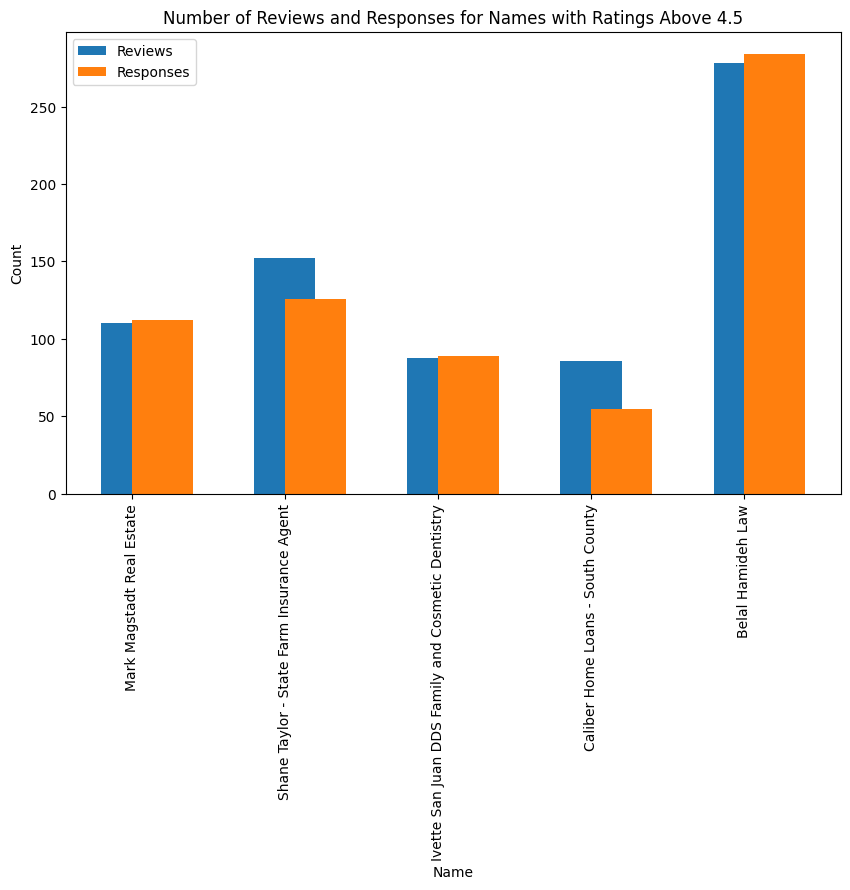

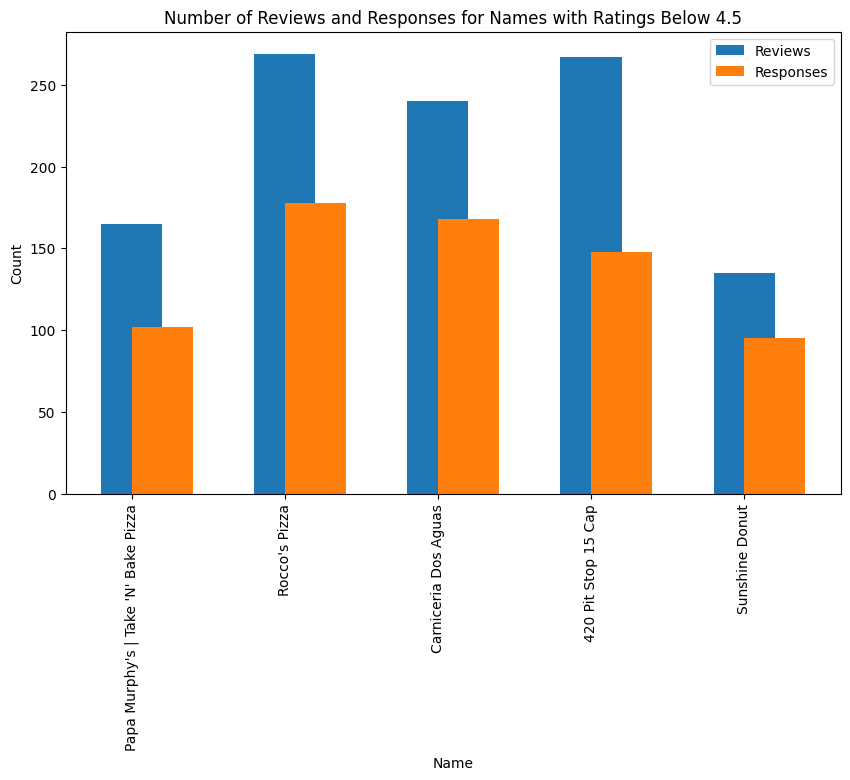

In [30]:
# Initialize dictionaries to hold the counts of reviews and responses
counts_above_4 = {}
counts_below_4 = {}

# Filter and count the reviews and responses for each gmap_id in top_5_above_4
for gmap_id in top_5_above_4:
    filtered_data = merged_data[merged_data['GmapID'] == gmap_id]
    #We want to count only those reviews that have text in them and not those that are saved as None
    review_count = filtered_data['Review'].notna().sum() + filtered_data['Review'].ne('None').sum()
    #We want to count only those responses that have text in them and not those that are saved as None
    response_count = filtered_data['Response'].notna().sum() + filtered_data['Response'].ne('None').sum()
    #Store the names of the businesses
    name = filtered_data['name'].iloc[0]
    counts_above_4[gmap_id] = {'name': name, 'Reviews': review_count, 'Responses': response_count}

# Filter and count the reviews and responses for each gmap_id in top_5_below_4
for gmap_id in top_5_below_4:
    filtered_data = merged_data[merged_data['GmapID'] == gmap_id]
    #We want to count only those reviews that have text in them and not those that are saved as None
    review_count = filtered_data['Review'].notna().sum() + filtered_data['Review'].ne('None').sum()
    #We want to count only those responses that have text in them and not those that are saved as None
    response_count = filtered_data['Response'].notna().sum() + filtered_data['Response'].ne('None').sum()
    #Store the names of the businesses
    name = filtered_data['name'].iloc[0]
    counts_below_4[gmap_id] = {'name': name, 'Reviews': review_count, 'Responses': response_count}

#We want to save all the variables in a list for ease of plotting
names_above = [counts_above_4[gmap_id]['name'] for gmap_id in counts_above_4.keys()]
review_counts_above = [counts_above_4[gmap_id]['Reviews'] for gmap_id in counts_above_4.keys()]
response_counts_above = [counts_above_4[gmap_id]['Responses'] for gmap_id in counts_above_4.keys()]

# Plotting for GmapIDs with rating above 4.5
plt.figure(figsize=(10, 6))
x_above = range(len(names_above))
plt.bar(x_above, review_counts_above, width=0.4, label='Reviews', align='center')
plt.bar(x_above, response_counts_above, width=0.4, label='Responses', align='edge')

plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Number of Reviews and Responses for Names with Ratings Above 4.5')
plt.xticks(ticks=x_above, labels=names_above, rotation=90)
plt.legend()
plt.show()

#We want to save all the variables in a list for ease of plotting
names_below = [counts_below_4[gmap_id]['name'] for gmap_id in counts_below_4.keys()]
review_counts_below = [counts_below_4[gmap_id]['Reviews'] for gmap_id in counts_below_4.keys()]
response_counts_below = [counts_below_4[gmap_id]['Responses'] for gmap_id in counts_below_4.keys()]

# Plotting for GmapIDs with rating below 4.5
plt.figure(figsize=(10, 6))
x_below = range(len(names_below))
plt.bar(x_below, review_counts_below, width=0.4, label='Reviews', align='center')
plt.bar(x_below, response_counts_below, width=0.4, label='Responses', align='edge')

plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Number of Reviews and Responses for Names with Ratings Below 4.5')
plt.xticks(ticks=x_below, labels=names_below, rotation=90)
plt.legend()
plt.show()


**Interpretation of the visulaisation:**

From above we notice that the High rated businesses have almost equal response and review count , that is for every review left the business has responded to the review , if it is positive or negative, this shows that the business is taking charge and trying to make a change and understand where they are lacking hence they would be able to improve over time and getter better ratings.


The businesses with low rating do not respond to all their reviews, and hence are not aware or not trying to make a change to their service or business and hence average out a lower rating.

<div class="alert alert-block alert-info">
    
### 6.3. How is Location of a business related to the Rating? <a class="anchor" name="DI1"></a>

To comapre the business location with the rating , we need to use the Location from the meta data and to get a better representation of the rating we use the average rating calculated in the previous steps from the Main Google review data. This average rating is calculated based on the reviews left and hence would be more accurate to classify as a high rating or low rating.

<ipython-input-32-4d0b5f5d6774>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['city'] = metadata['address'].apply(extract_city)


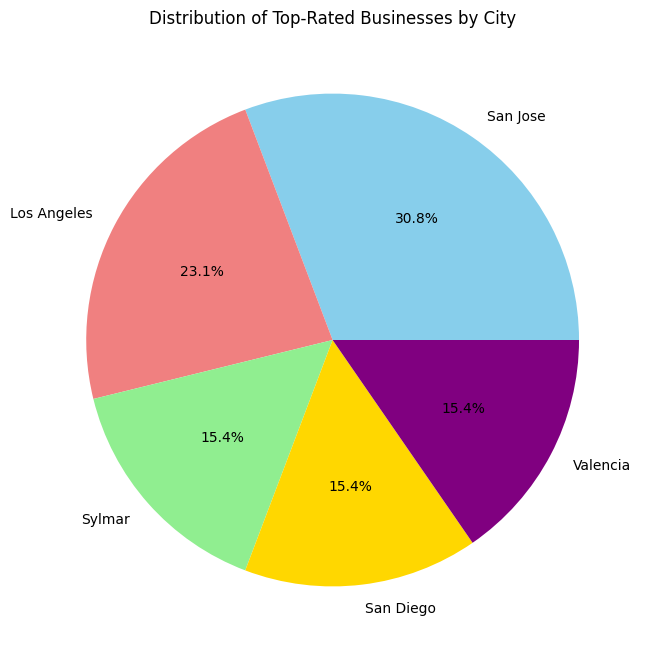

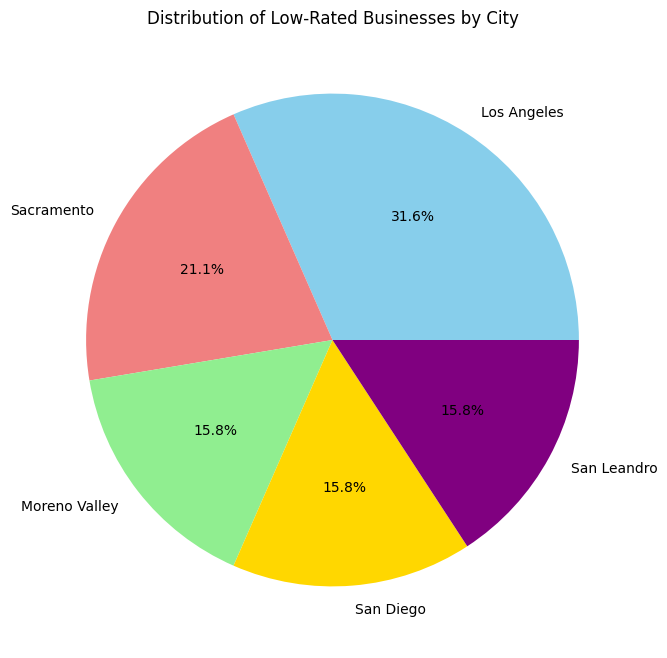

In [32]:
#This function extracts the state in which the business is located using regular expressions
def extract_city(address):
  #Check if address entry is NA
    if pd.notna(address):
      #Search for the words before CA
        match = re.search(r',\s*([^,]+)\s*,\s*CA', address)
        if match:
            return match.group(1).strip()  # Extract and strip spaces
    return None

# Apply the function to extract state names
metadata['city'] = metadata['address'].apply(extract_city)
#We use all the gmap_ids not just top 5
gmap_ids_above = gmap_ids_above_4.index.tolist()
gmap_ids_below = gmap_ids_below_4.index.tolist()

# Filter data for businesses in the top and bottom lists
top_businesses = metadata[metadata['gmap_id'].isin(gmap_ids_above)]
bottom_businesses = metadata[metadata['gmap_id'].isin(gmap_ids_below)]

# Count the number of businesses in each state for top and bottom businesses
top_city_counts = top_businesses['city'].value_counts().nlargest(5)
bottom_city_counts = bottom_businesses['city'].value_counts().nlargest(5)

# Plotting the top business locations using Pie Chart
plt.figure(figsize=(8, 8))
top_city_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'purple'])
plt.ylabel('')
plt.title('Distribution of Top-Rated Businesses by City')
plt.show()

# Plotting the bottom business locations using Pie Chart
plt.figure(figsize=(8, 8))
bottom_city_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'purple'])
plt.ylabel('')
plt.title('Distribution of Low-Rated Businesses by City')
plt.show()

**Interpretation of the visulaisation:**
From this insight we notice the top rated business are located in main States like Los Angeles, San Diego , San Jose . These are states that have a large population, a number of head quaters for big companies and famous among tourists as well and hence these businesses take their quality of service seriously and are able to gain a better rating.People may travel just to visit these businesses hence their average rating is higher.

Low rated business some are in Los Angeles , and Sacramento or Moreno Valley. These are states with smaller population and may not meet the best standards of service, they may also be far away from the city and main area and hence could recieve a lower rating.

<div class="alert alert-block alert-info">
    
### 6.4. How does sentiment impact the rating of a business?? <a class="anchor" name="DI1"></a>


This analysis explores the relationship between the sentiment of reviews and the average rating of businesses. The code performs the following steps:

It uses TextBlob to conduct sentiment analysis on each review, assigning a sentiment score.
The sentiment scores are averaged for each business.
These average sentiment scores are then compared to the average ratings of the businesses.
A correlation coefficient is calculated between the average sentiment and average rating.
Finally, a scatter plot is generated to visualize this relationship

In [33]:
#install if required
#!pip install textblob

In [34]:
# Function to get sentiment score
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis on the review text
merged_data['sentiment'] = merged_data['Review'].apply(lambda x: get_sentiment(str(x)))


In [35]:
# Calculate average sentiment scores  and average ratings of the businesse
sentiment_avg = merged_data.groupby('GmapID')['sentiment'].mean()
ratings_avg = merged_data.groupby('GmapID')['Rate'].mean()

# Combine these into a single DataFrame
sentiment_vs_rating = pd.DataFrame({'avg_sentiment': sentiment_avg, 'avg_rating': ratings_avg})

In [36]:
# Calculate the correlation between average sentiment and average ratin
correlation = sentiment_vs_rating['avg_sentiment'].corr(sentiment_vs_rating['avg_rating'])
print(f"Correlation between Average Sentiment and Average Rating: {correlation}")


Correlation between Average Sentiment and Average Rating: 0.7164365447127701


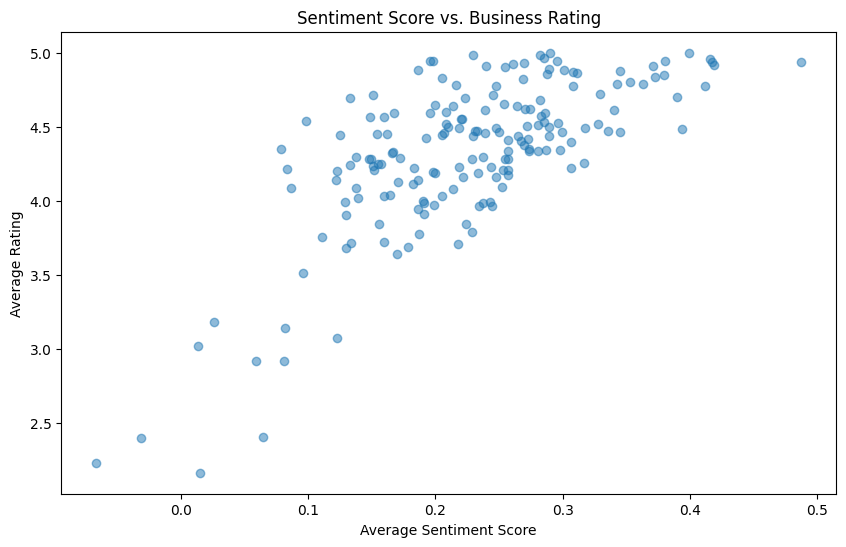

In [37]:

#plotting the scatter plot between average sentiment and average rating
from sklearn.feature_extraction.text import CountVectorizer

plt.figure(figsize=(10, 6))
plt.scatter(sentiment_vs_rating['avg_sentiment'], sentiment_vs_rating['avg_rating'], alpha=0.5)
plt.title('Sentiment Score vs. Business Rating')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Average Rating')
plt.show()# Perform bag of words analysis




**Interpretation of the visulaisation:**

The scatter plot shows a clear positive relationship between the average sentiment score of reviews and the average rating of businesses. This is supported by the high correlation coefficient of 0.7164, indicating a strong positive correlation.

This suggests that the emotional tone expressed in reviews closely aligns with the numerical ratings given. Most businesses cluster in the upper right quadrant, indicating predominantly positive sentiments and high ratings, while there's more variation in ratings for reviews with lower sentiment scores.

This strong relationship between sentiment and ratings underscores the importance of review content beyond just numerical scores.

For businesses, it highlights the need to focus on creating positive customer experiences that encourage favorable review sentiments, as these are likely to translate into higher ratings.
For consumers and analysts, it suggests that sentiment analysis of review text can provide valuable insights into business performance and customer satisfaction, potentially offering a more nuanced understanding than numerical ratings alone.

<div class="alert alert-block alert-info">
    
### 6.5. How does word usage impact the rating of a business? <a class="anchor" name="DI1"></a>

This analysis explores the relationship between specific words used in reviews and the ratings given to businesses. The code performs the following steps:

It uses CountVectorizer to convert review text into a bag-of-words representation.
It calculates the correlation between each word's frequency and the average rating of businesses.
The top 10 words with the highest positive correlation to ratings are identified.
These top 10 words are visualized in a bar chart, showing their correlation strength with ratings.

Top positive words: [('professional', 0.14380928285388928), ('recommend', 0.134109268321745), ('highly', 0.10746788426436704), ('thank', 0.10382497025355343), ('job', 0.10076365390027345), ('knowledgeable', 0.09357293385556079), ('great', 0.09213819373820406), ('helpful', 0.0897547169341044), ('friendly', 0.08214655002984078), ('work', 0.07474145994953384)]


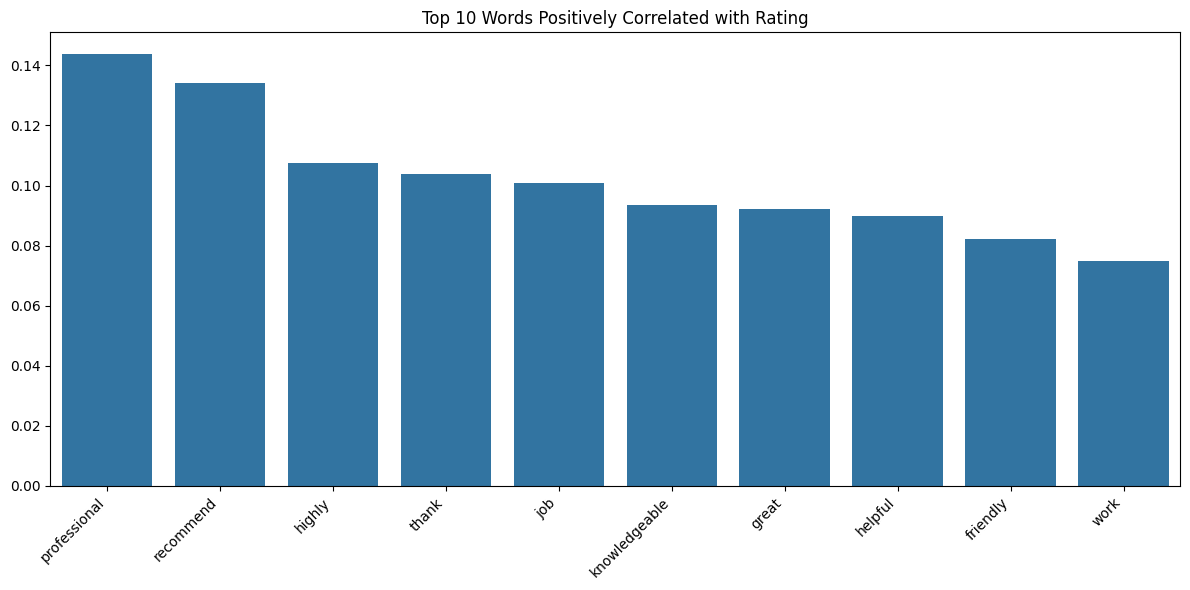

In [38]:

vectorizer = CountVectorizer(stop_words='english', max_features=100)
bow_matrix = vectorizer.fit_transform(merged_data['Review'].fillna(''))
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate correlation between word frequency and rating
word_rating_corr = {}
for word in bow_df.columns:
    word_rating_corr[word] = bow_df[word].corr(merged_data['avg_rating'])

# Get top positive and negative words
top_positive = sorted(word_rating_corr.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top positive words:", top_positive)

# Visualize top words
plt.figure(figsize=(12, 6))
sns.barplot(x=[word for word, corr in top_positive], y=[corr for word, corr in top_positive])
plt.title('Top 10 Words Positively Correlated with Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Interpretation of the visualisation**:

The analysis reveals specific words strongly associated with higher business ratings. "Professional" shows the strongest positive correlation (0.1438), followed by "recommend" (0.1341) and "highly" (0.1075).This indicates that reviews mentioning professionalism, positive recommendations, competence, and good customer service tend to correspond with higher ratings.

These findings suggest that businesses focusing on professionalism, encouraging recommendations, and providing knowledgeable, helpful service are more likely to receive higher ratings.

For businesses, this insight can guide service improvement strategies and review encouragement tactics.Consumers can use this information to better interpret reviews, while researchers may leverage these word associations to enhance sentiment analysis models for more accurate rating predictions based on review text.

**Summary:**


Our analysis of Google review data for businesses in California reveals that ratings are influenced by multiple factors beyond just the number of reviews. Active customer engagement, location, review sentiment, and specific language used in reviews all play significant roles. Businesses that maintain professionalism, encourage positive recommendations, and actively respond to customer feedback tend to achieve higher ratings. The strong correlation between review sentiment and ratings underscores the importance of creating positive customer experiences. These insights can guide businesses in improving their online reputation and help consumers better interpret review information. For researchers, this analysis provides a foundation for developing more sophisticated models to understand and predict business performance based on customer reviews.

<div class="alert alert-block alert-warning">

## 8. References <a class="anchor" name="Ref"></a>

</div>

1. Key aspects of EDA, https://www.geeksforgeeks.org/what-is-exploratory-data-analysis/ , Accesses on 28/8/2024

2. What kind of visulaisation to use for different data variables ? https://www.data-to-viz.com/. , Accessed on 28/8/2024

3. Text Analytics & Visualization, https://guides.lib.uw.edu/research/text-mining/text-analytics, Accessed on 29/8/2024